In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os, sys, datetime, time, random, fnmatch, math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import skimage.metrics

import torch
from torchvision import transforms as tvtransforms
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.utils as vutils
import torch.utils.tensorboard as tensorboard
import torch.nn as nn
import torch.optim as optim

import datasets, custom_transforms, RajaramanModel, pytorch_msssim

flag_debug = False
flag_load_previous_save = False

# Input Directories
#data_BSE = "D:/data/JSRT/augmented/train/target/"
#data_normal = "D:/data/JSRT/augmented/train/source/"
data_BSE = "G:/DanielLam/JSRT/HQ_JSRT_and_BSE-JSRT/177-20-20 split/train_augmented_noEqualise/suppressed/"
data_normal = "G:/DanielLam/JSRT/HQ_JSRT_and_BSE-JSRT/177-20-20 split/train_augmented_noEqualise/normal/"

data_val_normal = 'G:/DanielLam/JSRT/HQ_JSRT_and_BSE-JSRT/177-20-20 split/validate/normal'
data_val_BSE = 'G:/DanielLam/JSRT/HQ_JSRT_and_BSE-JSRT/177-20-20 split/validate/suppressed/'

# Save directories:
output_save_directory = Path("./runs/Rajaraman_ResNet/v2_HQ_noEqualised_177-20-20")
output_save_directory.mkdir(parents=True, exist_ok=True)
PATH_SAVE_NETWORK_INTERMEDIATE = os.path.join(output_save_directory, 'network_intermediate.tar' )
PATH_SAVE_NETWORK = os.path.join(output_save_directory, 'network_final.pt')

# Image Size:
image_spatial_size = (256,256)
_batch_size = 8


# Optimisation
lr_ini = 0.001
beta1 = 0.9
beta2 = 0.999

# Training
total_num_epochs = 200

# Weight Initialisation
def weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight.data, 0., 0.02)
        #nn.init.kaiming_normal_(m.weight.data,0)
        try:
            nn.init.constant_(m.bias.data, 0.)
        except:
            pass
    if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.InstanceNorm2d):
        if m.affine:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0.)

## Code for putting things on the GPU
ngpu = 1 #torch.cuda.device_count()
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
device = torch.device("cuda" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)
if (torch.cuda.is_available()):
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
    if ngpu ==1:
        device=torch.device('cuda:1')

cuda
GeForce RTX 2080 Ti


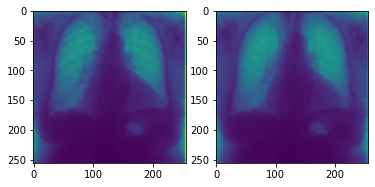

In [2]:
# Current date:
current_date=datetime.datetime.today().strftime('%Y-%m-%d')

# Data Loader
original_key = "source"
target_key = "boneless"
discriminator_keys_images = [original_key, target_key]

ds_training = datasets.JSRT_CXR(data_normal, data_BSE,
                         transform=tvtransforms.Compose([
                             # custom_transforms.HistogramEqualisation(discriminator_keys_images),-- check if training data is already equalised
                             custom_transforms.Resize(discriminator_keys_images, image_spatial_size),
                             custom_transforms.ToTensor(discriminator_keys_images),
                             ])
                      )
ds_val = datasets.JSRT_CXR(data_val_normal, data_val_BSE,
                         transform=tvtransforms.Compose([
                             #custom_transforms.HistogramEqualisation(discriminator_keys_images),
                             custom_transforms.Resize(discriminator_keys_images, image_spatial_size),
                             custom_transforms.ToTensor(discriminator_keys_images),
                             ])
                      )
# SPLIT DATA INTO TRAINING/VALIDATION SET
dl_training = DataLoader(ds_training, batch_size=_batch_size,
                         shuffle=True, num_workers=0)

dl_validation = DataLoader(ds_val, batch_size=len(ds_val),
                         shuffle=True, num_workers=0)
fixed_val_sample = next(iter(dl_validation))

fig, ax = plt.subplots(1,2)
ax[0].imshow(fixed_val_sample[original_key][0,0,:])
ax[1].imshow(fixed_val_sample[target_key][0,0,:])
plt.show()

In [3]:
## Implementation of network and losses
input_array_size = (_batch_size, 1, image_spatial_size[0], image_spatial_size[1])
net = RajaramanModel.ResNet_BS(input_array_size)
# Initialise weights
net.apply(weights_init)

# Multi-GPU
if (device.type == 'cuda') and (ngpu > 1):
    print("Neural Net on GPU")
    net = nn.DataParallel(net, list(range(ngpu)))
net = net.to(device)

# Optimiser
optimizer = optim.Adam(net.parameters(), lr=lr_ini, betas=(beta1, beta2))

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                 factor=0.5, patience=10, 
                                                 threshold=0.0001, min_lr=0.00001, verbose=True)

# Gusarev Loss
def criterion_Rajaraman(testImage, referenceImage, alpha=0.84):
    """
    Generates a loss over a mini-batch of images.
    Outputs scalars.
    Rajaraman, S., Zamzmi, G., Folio, L., Alderson, P., & Antani, S. (2021). Chest X-Ray Bone Suppression for Improving Classification of Tuberculosis-Consistent Findings. In Diagnostics (Vol. 11, Issue 5). https://doi.org/10.3390/diagnostics11050840
    """
    mae = nn.L1Loss() # L2 used for easier optimisation c.f. L1
    mae_loss = mae(testImage, referenceImage)
    msssim = pytorch_msssim.MSSSIM(window_size=11, size_average=True, channel=1, normalize='relu')
    msssim_loss = 1 - msssim(testImage, referenceImage)
    total_loss = (1-alpha)*mae_loss + alpha*msssim_loss
    return total_loss, mae_loss, msssim_loss

In [4]:
# Training
epochs_list = []
img_list = []
training_loss_list = []
reals_shown = []
#validation_loss_per_epoch_list = []
#training_loss_per_epoch_list = []
loss_per_epoch={"training":[], "validation":[]}
ssim_average={"training":[], "validation":[]}

# For each epoch
print(target_key)

# optionally resume from a checkpoint
if flag_load_previous_save:
    if os.path.isfile(PATH_SAVE_NETWORK_INTERMEDIATE):
        print("=> loading checkpoint '{}'".format(PATH_SAVE_NETWORK_INTERMEDIATE))
        checkpoint = torch.load(PATH_SAVE_NETWORK_INTERMEDIATE)
        start_epoch = checkpoint['epoch_next']
        reals_shown_now = checkpoint['reals_shown']
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        net.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print("=> loaded checkpoint '{}' (epoch {}, reals shown {})".format(PATH_SAVE_NETWORK_INTERMEDIATE, 
                                                                            start_epoch, reals_shown_now))
        print(scheduler)
    else:
        print("=> NO CHECKPOINT FOUND AT '{}'" .format(PATH_SAVE_NETWORK_INTERMEDIATE))
        raise RuntimeError("No checkpoint found at specified path.")
else:
    print("FLAG: NO CHECKPOINT LOADED.")
    reals_shown_now = 0
    start_epoch=0

# Loop variables
flag_break = False # when debugging, this will automatically go to True
iters = 0
net.train()
for param in net.parameters():
    param.requires_grad = True
for epoch in range(start_epoch, total_num_epochs):
    print(optimizer.param_groups[0]['lr'])
    sum_loss_in_epoch = 0
    for i, data in enumerate(dl_training):
        # Training
        net.zero_grad()
        noisy_data = data[original_key].to(device)
        cleaned_data = net(noisy_data)
        loss, maeloss, msssim_loss = criterion_Rajaraman(cleaned_data, data[target_key].to(device))
        loss.backward() # calculate gradients
        optimizer.step() # optimiser step along gradients
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tTotal Loss: %.4f\tMAELoss: %.4f\tMSSSIM Loss: %.4f'
                  % (epoch, total_num_epochs, i, len(dl_training),
                     loss.item(), maeloss.item(), msssim_loss.item()))
        # Record generator output
        if reals_shown_now%(100*_batch_size)==0:
            with torch.no_grad():
                val_cleaned = net(fixed_val_sample["source"].to(device)).detach().cpu()
            print("Printing to img_list")
            img_list.append(vutils.make_grid(val_cleaned, padding=2, normalize=True))
        iters +=1
        if flag_debug and iters>=10:
            flag_break = True
            break
        
        # Running counter of reals shown
        reals_shown_now += _batch_size
        reals_shown.append(reals_shown_now)
        
        # Training loss list for loss per minibatch
        training_loss_list.append(loss.item()) # training loss
        sum_loss_in_epoch += loss.item()*len(cleaned_data)
    # Turn the sum loss in epoch into a loss-per-epoch
    loss_per_epoch["training"].append(sum_loss_in_epoch/len(ds_training))
    
    
    with torch.no_grad():
        # Training Accuracy per EPOCH
        ssim_training_list = []
        for train_count, data in enumerate(dl_training):
            noisy_training_data = data[original_key].to(device)
            true_training_data = data[target_key]
            cleaned_training_data = net(noisy_training_data)
            
            for ii, image in enumerate(cleaned_training_data):
                clean_training_numpy = image.cpu().detach().numpy()
                true_training_numpy = true_training_data[ii].numpy()
                clean_training_numpy = np.moveaxis(clean_training_numpy, 0, -1)
                true_training_numpy = np.moveaxis(true_training_numpy, 0, -1)
                ssim_training = skimage.metrics.structural_similarity(clean_training_numpy, true_training_numpy, multichannel=True)
                ssim_training_list.append(ssim_training) # SSIM per image
        ssim_average["training"].append(np.mean(ssim_training_list))
        
        # Validation Loss and Accuracy per EPOCH
        sum_loss_in_epoch =0
        ssim_val_list = []
        for val_count, sample in enumerate(dl_validation):
            noisy_val_data = sample[original_key].to(device)
            cleaned_val_data = net(noisy_val_data)
            
            # Loss
            true_val_data = sample[target_key]
            val_loss, maeloss, msssim_loss = criterion_Rajaraman(cleaned_val_data, true_val_data.to(device))
            sum_loss_in_epoch += val_loss.item()*len(cleaned_val_data)
            
            # Accuracy
            for ii, image in enumerate(cleaned_val_data):
                clean_val_numpy = image.cpu().detach().numpy()
                true_val_numpy = true_val_data[ii].numpy()
                clean_val_numpy = np.moveaxis(clean_val_numpy, 0, -1)
                true_val_numpy = np.moveaxis(true_val_numpy, 0, -1)
                ssim_val = skimage.metrics.structural_similarity(clean_val_numpy, true_val_numpy, multichannel=True)
                ssim_val_list.append(ssim_val) # SSIM per image
        # After considering all validation images
        loss_per_epoch["validation"].append(sum_loss_in_epoch/len(ds_val))
        ssim_average["validation"].append(np.mean(ssim_val_list))
    epochs_list.append(epoch)
    # LR Scheduler after epoch
    scheduler.step(val_loss)
    
    # Save the network in indications
    if epoch % 5 == 0:
        if not flag_debug:
            #torch.save(net.state_dict(), PATH_SAVE_NETWORK_INTERMEDIATE)
            torch.save({
            'epochs_completed': epoch+1,
            'epoch_next': epoch+1,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'scheduler_state_dict': scheduler.state_dict(),
            'reals_shown': reals_shown_now
            }, PATH_SAVE_NETWORK_INTERMEDIATE)
            print("Saved Intermediate: "+ str(PATH_SAVE_NETWORK_INTERMEDIATE))
    if flag_break:
        break

if not flag_debug:
    torch.save(net.state_dict(), PATH_SAVE_NETWORK)
    
    torch.save({
            'epochs_completed': epoch+1,
            'epoch_next': epoch+1,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'scheduler_state_dict': scheduler.state_dict(),
            'reals_shown': reals_shown_now
            }, PATH_SAVE_NETWORK_INTERMEDIATE)
    print("Saved Intermediate: "+ str(PATH_SAVE_NETWORK_INTERMEDIATE))
    

boneless
FLAG: NO CHECKPOINT LOADED.
0.001
[0/200][0/509]	Total Loss: 0.7634	MAELoss: 0.2945	MSSSIM Loss: 0.8527
Printing to img_list
[0/200][50/509]	Total Loss: 0.0331	MAELoss: 0.0423	MSSSIM Loss: 0.0314
[0/200][100/509]	Total Loss: 0.0281	MAELoss: 0.0312	MSSSIM Loss: 0.0276
Printing to img_list
[0/200][150/509]	Total Loss: 0.0236	MAELoss: 0.0259	MSSSIM Loss: 0.0231
[0/200][200/509]	Total Loss: 0.0309	MAELoss: 0.0257	MSSSIM Loss: 0.0318
Printing to img_list
[0/200][250/509]	Total Loss: 0.0299	MAELoss: 0.0231	MSSSIM Loss: 0.0312
[0/200][300/509]	Total Loss: 0.0233	MAELoss: 0.0224	MSSSIM Loss: 0.0235
Printing to img_list
[0/200][350/509]	Total Loss: 0.0230	MAELoss: 0.0218	MSSSIM Loss: 0.0232
[0/200][400/509]	Total Loss: 0.0253	MAELoss: 0.0219	MSSSIM Loss: 0.0259
Printing to img_list
[0/200][450/509]	Total Loss: 0.0234	MAELoss: 0.0218	MSSSIM Loss: 0.0237
[0/200][500/509]	Total Loss: 0.0201	MAELoss: 0.0209	MSSSIM Loss: 0.0199
Printing to img_list
Saved Intermediate: runs\Rajaraman_ResNet\

In [5]:
print("Training complete")

# CHECKPOINT SAVE
PATH_SAVE_NETWORK_FINAL = os.path.join(output_save_directory, 'network_final.tar' )
torch.save({
            'epochs_completed': epoch+1,
            'epoch_next': epoch+1,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'scheduler_state_dict': scheduler.state_dict(),
            'reals_shown': reals_shown_now
            }, PATH_SAVE_NETWORK_FINAL)
print("Saved Checkpoint '{}' at epoch {}".format(PATH_SAVE_NETWORK_FINAL, epoch+1))

Training complete
Saved Checkpoint 'runs\Rajaraman_ResNet\v2_HQ_noEqualised_177-20-20\network_final.tar' at epoch 200


tensor(1.0000),tensor(0.)


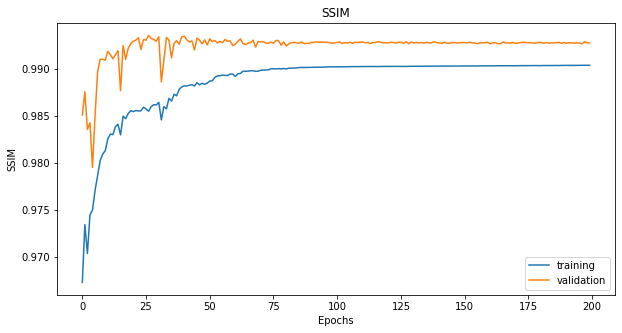

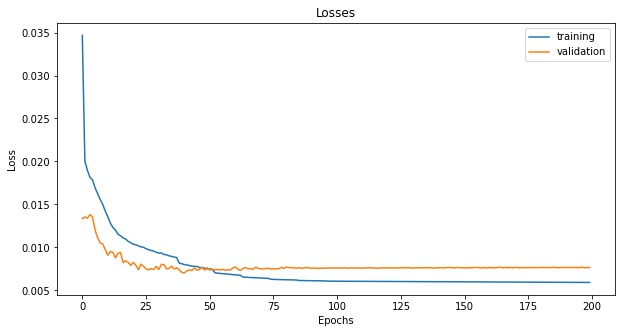

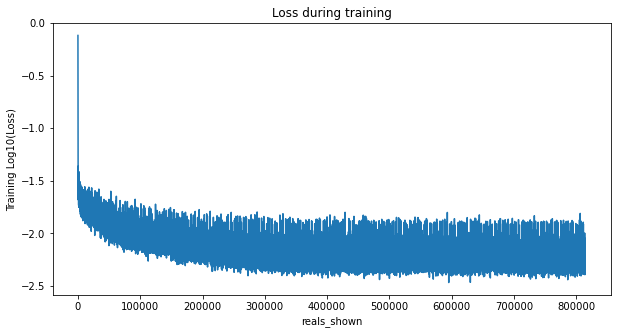

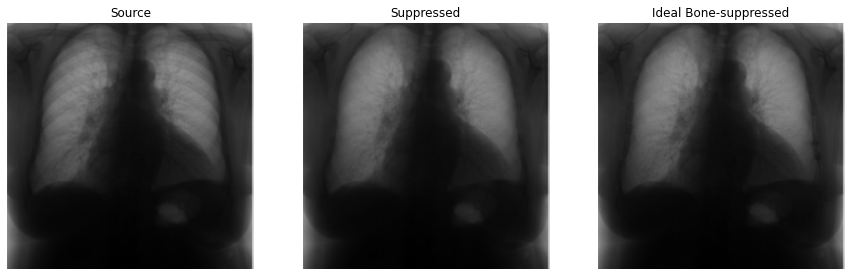

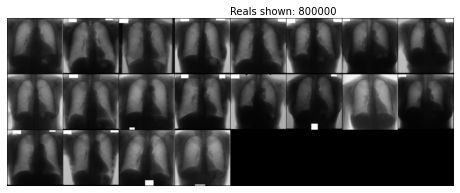

In [6]:
%matplotlib inline
import math
current_date=datetime.datetime.today().strftime('%Y-%m-%d')

# Accuracy
plt.figure(figsize=(10,5))
plt.title("SSIM")
plt.plot(epochs_list, ssim_average["training"], label='training')
plt.plot(epochs_list, ssim_average["validation"] , label='validation')
plt.xlabel("Epochs")
plt.ylabel("SSIM")
plt.legend()
if not flag_debug:
    plt.savefig(os.path.join(output_save_directory, current_date + "_accuracy"+".png"))
    
# All losses
plt.figure(figsize=(10,5))
plt.title("Losses")
plt.plot(epochs_list, loss_per_epoch["training"], label='training')
plt.plot(epochs_list, loss_per_epoch["validation"] , label='validation')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
if not flag_debug:
    plt.savefig(os.path.join(output_save_directory, current_date + "_loss"+".png"))

# Loss for training
plt.figure(figsize=(10,5))
plt.title("Loss during training")
plt.plot(reals_shown, [math.log10(y) for y in training_loss_list])
plt.xlabel("reals_shown")
plt.ylabel("Training Log10(Loss)")
if not flag_debug:
    plt.savefig(os.path.join(output_save_directory, current_date + "_training_loss"+".png"))


    
# Final Model:
with torch.no_grad():
    input_image = fixed_val_sample['source']
    input_images = vutils.make_grid(input_image[0:1,:,:,:], padding=2, normalize=True)
    target_images = vutils.make_grid(fixed_val_sample['boneless'][0:1,:,:,:], padding=2, normalize=True)
    net = net.cpu()
    output_image = net(input_image[0:1,:,:,:]).detach().cpu()
    output_images = vutils.make_grid(output_image, padding=2, normalize=True)
print(str(torch.max(output_images)) + "," + str(torch.min(output_images)))
plt.figure(1)
fig, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(np.transpose(input_images, (1,2,0)), vmin=0, vmax=1)
ax[0].set_title("Source")
ax[0].axis("off")
ax[1].imshow(np.transpose(output_images, (1,2,0)), vmin=0, vmax=1)
ax[1].set_title("Suppressed")
ax[1].axis("off")
ax[2].imshow(np.transpose(target_images, (1,2,0)), vmin=0, vmax=1)
ax[2].set_title("Ideal Bone-suppressed")
ax[2].axis("off")
plt.show
if not flag_debug:
    plt.savefig(os.path.join(output_save_directory, current_date + "_validation_ComparisonImages"+".png"))

# ANIMATED VALIDATION IMAGE
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plt.axis("off")
ims = []
training_ims_shown = []
for i, im in enumerate(img_list):
    if i % 50 == 0:  # controls how many images are printed into the animation
        training_ims_shown = i*(100*_batch_size)
        frame = ax.imshow(np.transpose(im,(1,2,0)))
        t = ax.annotate("Reals shown: {}".format(training_ims_shown), (0.5,1.02), xycoords="axes fraction")
        ims.append([frame, t])
ani = animation.ArtistAnimation(fig, ims, interval=200, repeat_delay=1000, blit=True)
if not flag_debug:
    ani.save(os.path.join(output_save_directory, current_date+"_animation.mp4"), dpi=300)

In [7]:
clean_matrix = torch.from_numpy(np.random.rand(15,1,256,256)).float()
true_matrix = torch.from_numpy(np.random.rand(15,1,256,256)).float()
print(criterion_Rajaraman(clean_matrix, true_matrix, alpha=0.84))
print(len(true_matrix))
print(len(ds_training))

(tensor(0.8218), tensor(0.3335), tensor(0.9148))
15
4071


In [8]:
ssim_average["validation"]

[0.9850778341773727,
 0.9875353539476658,
 0.9835533573279698,
 0.9842449412438166,
 0.9795037157173156,
 0.9850194211980199,
 0.9896761913244048,
 0.9909973913001655,
 0.9909926755611675,
 0.9909144579656388,
 0.9918354282617043,
 0.9914856904459903,
 0.991046420258203,
 0.9914843809038103,
 0.9919111943617631,
 0.9876704168306925,
 0.9924557940574903,
 0.99099281582609,
 0.9921621587796858,
 0.9926482637299774,
 0.9929152783822882,
 0.9930333602580195,
 0.9932849410235803,
 0.992037994394505,
 0.9931044484809186,
 0.9930310157616777,
 0.9935407118362605,
 0.9932054627042763,
 0.9931124380259412,
 0.9929115105147117,
 0.9933935452917009,
 0.9885965161059309,
 0.9908895566118041,
 0.9933165858309627,
 0.9930171799631438,
 0.9911500883088191,
 0.9926813738633236,
 0.9929711777941772,
 0.9925957574845998,
 0.9933915417456625,
 0.9934628364582908,
 0.9930573586569817,
 0.9928293415084616,
 0.992951389650452,
 0.9919873622482795,
 0.9932502949116904,
 0.9930126272220349,
 0.992639588065759